In [118]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import numpy as np 
import pandas as pd
from sklearn.manifold import TSNE



from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [119]:

# Load the .mat file
mat_file_path = "dataset/BRCA1View1000.mat"
mat_data = scipy.io.loadmat(mat_file_path)


In [120]:
# Inspect the keys in the .mat file
print("Keys in the MAT file:", mat_data.keys())

Keys in the MAT file: dict_keys(['__header__', '__version__', '__globals__', 'data', 'targets'])


In [121]:
# Extract the gene expression matrix and target labels
X = mat_data['data']          # shape: genes x samples
y = mat_data['targets'].flatten()  # shape: samples



In [122]:
print("\nShape of gene expression matrix (genes x samples):", X.shape)
print("Shape of target vector (samples):", y.shape)
print("Unique classes:", np.unique(y))


Shape of gene expression matrix (genes x samples): (1000, 2133)
Shape of target vector (samples): (2133,)
Unique classes: [1 2 3 4 5 6]


In [123]:
# Optional - basic statistics
print("\nGene expression statistics:")
print("Min:", X.min(), "Max:", X.max())
print("Mean:", X.mean(), "Std:", X.std())


Gene expression statistics:
Min: 0.0 Max: 1.0
Mean: 0.3314029448560866 Std: 0.1931370862564709


In [124]:
# Converting to DataFrame for further steps(samples x genes)
gene_df = pd.DataFrame(X.T)  # transposing so rows = samples, columns = genes
gene_df['Subtype'] = y       # adding target labels as a new column

print("\nFirst 5 rows of the dataset:")
print(gene_df.head())


First 5 rows of the dataset:
          0         1         2         3         4         5         6  \
0  0.276338  0.243315  0.098696  0.948949  0.424548  0.728649  0.576157   
1  0.998155  0.491584  0.682874  0.518834  0.128112  0.036587  0.828786   
2  0.464005  0.127223  0.150458  0.313084  0.198929  0.101602  0.889156   
3  0.708256  0.990991  0.227884  0.413478  0.248705  0.674076  0.559691   
4  0.912457  1.000000  0.802602  0.581899  0.369224  0.057715  0.546891   

          7         8         9  ...       991       992       993       994  \
0  0.373383  0.131070  0.302040  ...  0.380823  0.868204  0.151193  0.286462   
1  0.161189  0.131813  0.186915  ...  0.325502  1.000000  0.118998  0.526340   
2  0.553299  0.622338  0.802808  ...  0.441346  0.905243  0.087547  0.354501   
3  0.484117  0.206005  0.554822  ...  0.478284  0.967476  0.115522  0.339239   
4  0.734533  0.104131  0.394168  ...  0.421073  0.797633  0.128767  0.220795   

        995       996       997       

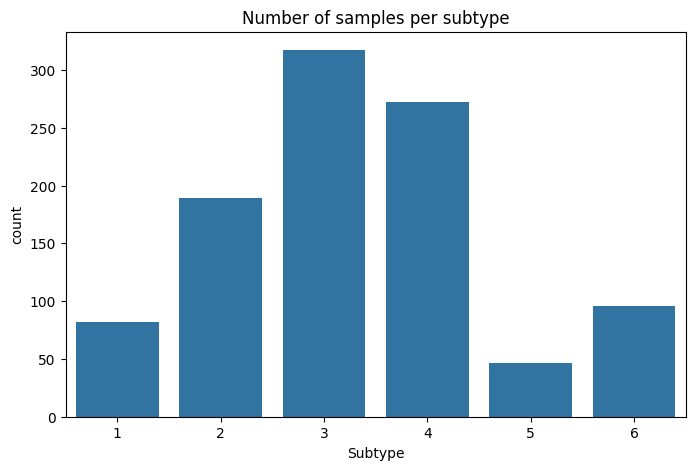

In [125]:
plt.figure(figsize=(8,5))
sns.countplot(x='Subtype', data=gene_df)
plt.title("Number of samples per subtype")
plt.show()

In [126]:
# Count number of samples in each subtype
class_counts = gene_df['Subtype'].value_counts()
print("Number of samples per subtype:")
print(class_counts)

Number of samples per subtype:
Subtype
4    776
3    630
1    266
2    251
6    144
5     66
Name: count, dtype: int64


In [127]:
gene_stats = gene_df.drop(columns='Subtype').describe().T
print(gene_stats.head())  


    count      mean       std       min       25%       50%       75%  max
0  2133.0  0.614005  0.311630  0.000000  0.339460  0.679522  0.910286  1.0
1  2133.0  0.470317  0.308354  0.022711  0.189185  0.395468  0.750537  1.0
2  2133.0  0.425992  0.298759  0.000000  0.145726  0.373967  0.679212  1.0
3  2133.0  0.589873  0.298137  0.015603  0.337417  0.638789  0.855400  1.0
4  2133.0  0.431111  0.278175  0.020986  0.160396  0.425025  0.659510  1.0


In [128]:
missing = gene_df.isnull().sum().sum()
print("Total missing values in dataset:", missing)

Total missing values in dataset: 0


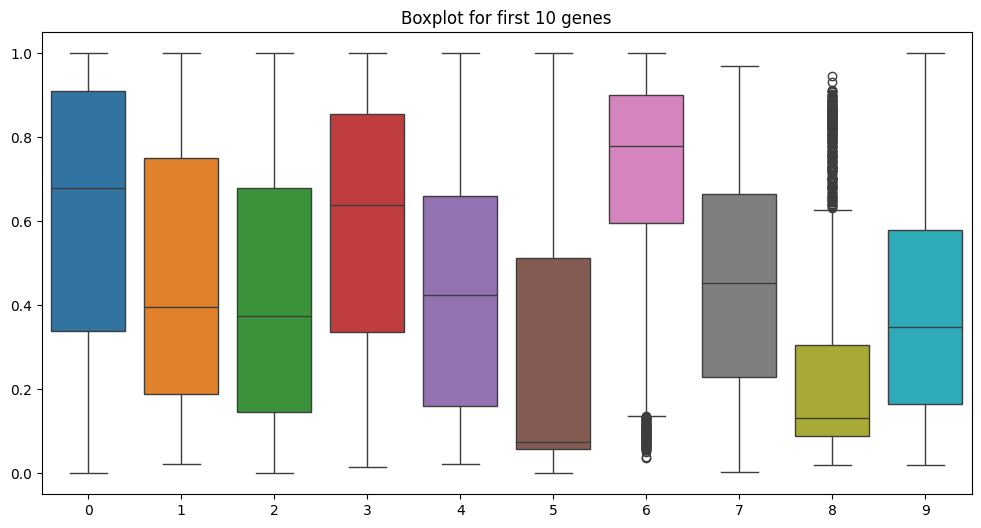

In [129]:
plt.figure(figsize=(12,6))
#first 10 genes
sns.boxplot(data=gene_df.iloc[:, :10])  
plt.title("Boxplot for first 10 genes")
plt.show()


In [130]:
# Separate features and target
X = gene_df.drop('Subtype', axis=1)
y = gene_df['Subtype']

# Apply Z-score standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a new DataFrame with standardized data
gene_df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
gene_df_scaled['Subtype'] = y


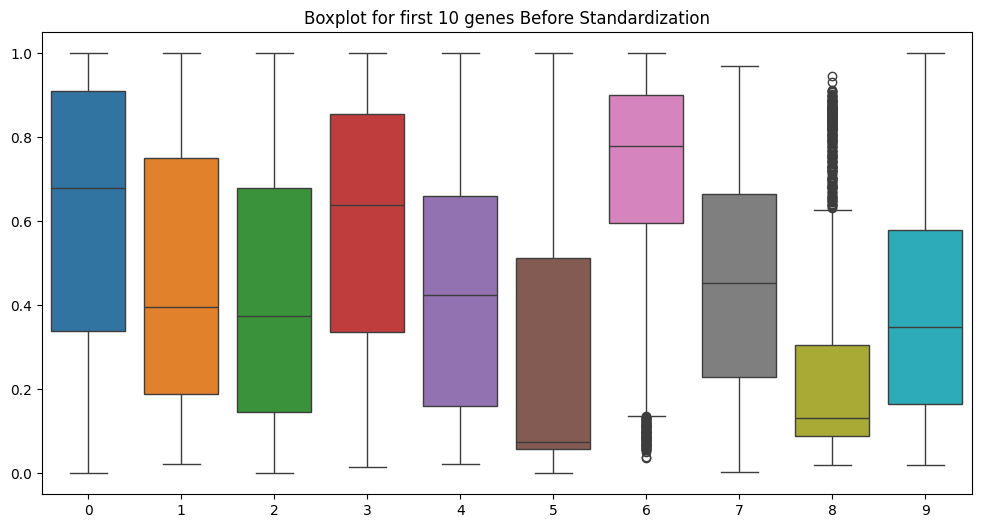

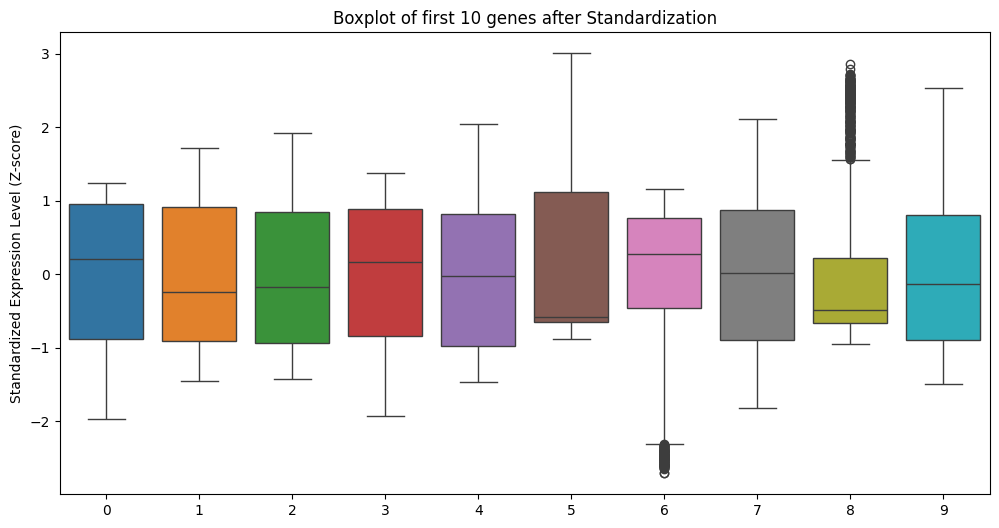

In [131]:
# Plot boxplot for the first 10 genes (for visualization)
plt.figure(figsize=(12,6))
sns.boxplot(data=gene_df.iloc[:, :10])  
plt.title("Boxplot for first 10 genes Before Standardization")
plt.show()


plt.figure(figsize=(12,6))
sns.boxplot(data=gene_df_scaled.iloc[:, :10]) 
plt.title('Boxplot of first 10 genes after Standardization')
plt.ylabel('Standardized Expression Level (Z-score)')
plt.show()


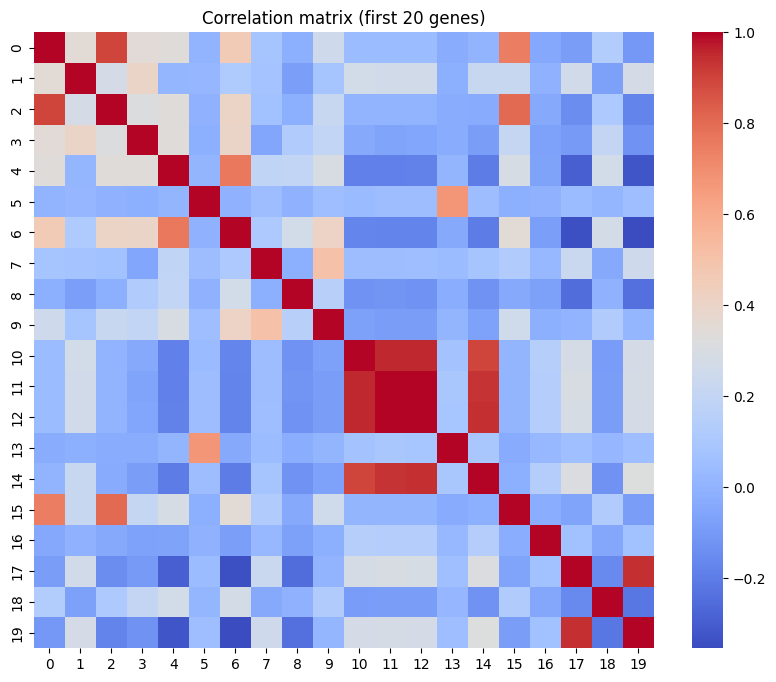

In [132]:
# Compute correlation for first 20 genes to keep it readable
corr_matrix = gene_df_scaled.iloc[:, :20].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation matrix (first 20 genes)")
plt.show()


In [133]:
# Check for missing values
print("Missing values per column:")
print(gene_df_scaled.isna().sum().head())

print("\nTotal missing values:", gene_df_scaled.isna().sum().sum())

Missing values per column:
0    0
1    0
2    0
3    0
4    0
dtype: int64

Total missing values: 0


In [134]:
# compute variance on original data before scaling
gene_variances_raw = gene_df.drop(columns=['Subtype']).var()

# sort by variance (descending)
top_genes_raw = gene_variances_raw.sort_values(ascending=False)

print(top_genes_raw.head(20))


0     0.097113
1     0.095082
2     0.089257
3     0.088886
4     0.077382
5     0.066203
6     0.061812
7     0.060541
8     0.059156
9     0.059109
10    0.058767
11    0.058735
12    0.056718
13    0.055271
14    0.052744
15    0.051607
16    0.051518
17    0.051358
18    0.049381
19    0.047981
dtype: float64


In [135]:
# compute variance on data after scaling
gene_variances_raw = gene_df_scaled.drop(columns=['Subtype']).var()

# sort by variance (descending)
top_genes_raw = gene_variances_raw.sort_values(ascending=False)

print(top_genes_raw.head(20))


236    1.000469
159    1.000469
50     1.000469
486    1.000469
710    1.000469
15     1.000469
396    1.000469
805    1.000469
315    1.000469
6      1.000469
440    1.000469
574    1.000469
164    1.000469
176    1.000469
813    1.000469
849    1.000469
42     1.000469
939    1.000469
733    1.000469
33     1.000469
dtype: float64


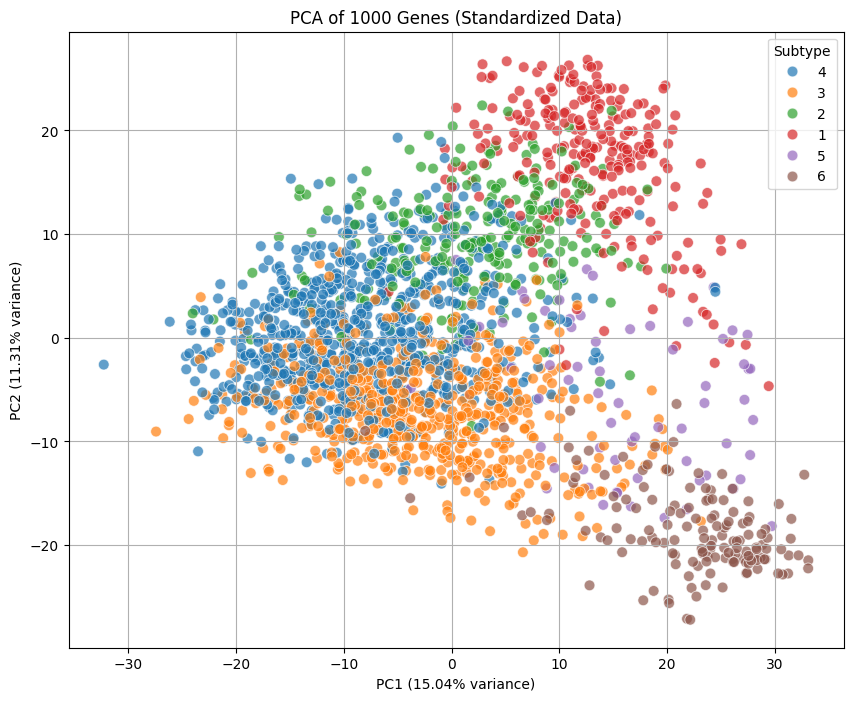

In [136]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(gene_df_scaled.drop(columns=['Subtype']))

# Converting into Dataframe for visualization purposes
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Subtype'] = gene_df_scaled['Subtype'].values.astype(str)  

# Visualization
plt.figure(figsize=(10,8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Subtype',
    palette='tab10',
    data=pca_df,
    alpha=0.7,
    s=60
)
plt.title('PCA of 1000 Genes (Standardized Data)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
plt.legend(title='Subtype')
plt.grid(True)
plt.show()

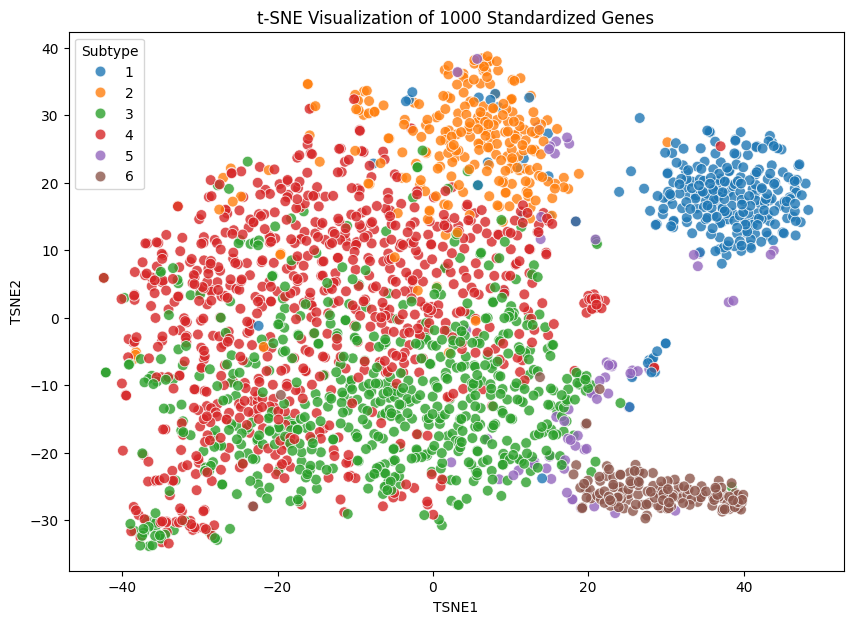

In [137]:
X = gene_df_scaled.drop(columns=['Subtype'])


y = gene_df_scaled['Subtype']

# t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42
)

X_tsne = tsne.fit_transform(X)

# Prepare DataFrame for plotting
tsne_df = pd.DataFrame({
    "TSNE1": X_tsne[:, 0],
    "TSNE2": X_tsne[:, 1],
    "Subtype": y
})

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tsne_df,
    x="TSNE1",
    y="TSNE2",
    hue="Subtype",
    palette="tab10",
    alpha=0.8,
    s=60
)
plt.title("t-SNE Visualization of 1000 Standardized Genes")
plt.show()


In [138]:
# Original labels
y = gene_df_scaled['Subtype']

# sLabel Encoding for ML models (integers 0-5)
y_int = y - 1
print("Label Encoded (0-5) sample:")
print(y_int.head())

Label Encoded (0-5) sample:
0    3
1    2
2    2
3    1
4    3
Name: Subtype, dtype: uint8


In [139]:
# Separate features and target
X = gene_df.drop('Subtype', axis=1)  # original DataFrame without scaling
y = gene_df['Subtype']

In [140]:

# Split the dataset: Train / Validation / Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Check sizes
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train: (1706, 1000), Validation: (213, 1000), Test: (214, 1000)


In [141]:
# Label Encoding (for ML models: integers 0-5)
# Original labels are 1-6, so subtract 1
y_train_int = y_train - 1
y_val_int = y_val - 1
y_test_int = y_test - 1

print("Sample Label Encoded (0-5):")
print(y_train_int.head())

Sample Label Encoded (0-5):
675     3
1033    2
86      1
1612    0
1424    3
Name: Subtype, dtype: uint8


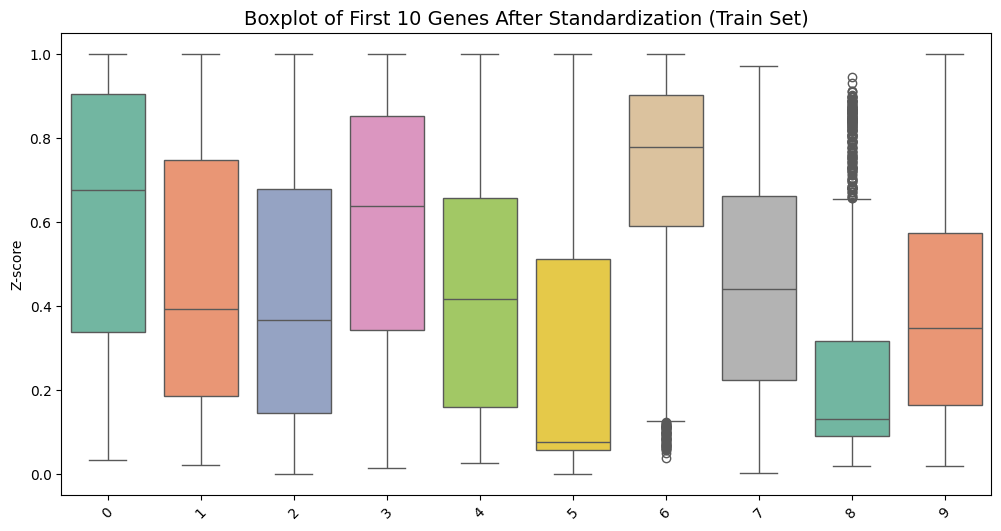

In [142]:

train_df_scaled = pd.DataFrame(X_train, columns=X_train.columns)

# Boxplot for first 10 genes
plt.figure(figsize=(12,6))
sns.boxplot(data=train_df_scaled.iloc[:, :10], palette="Set2")
plt.title("Boxplot of First 10 Genes After Standardization (Train Set)", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Z-score")
plt.show()

In [143]:
# 4️⃣ Standardization (fit only on training set)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [144]:
print("Train mean (should be ~0):", np.mean(X_train_scaled, axis=0)[:5])
print("Train std (should be ~1):", np.std(X_train_scaled, axis=0)[:5])

Train mean (should be ~0): [ 1.99866175e-15 -1.67880559e-15  2.13551984e-15  1.15232820e-15
  2.45993144e-17]
Train std (should be ~1): [1. 1. 1. 1. 1.]


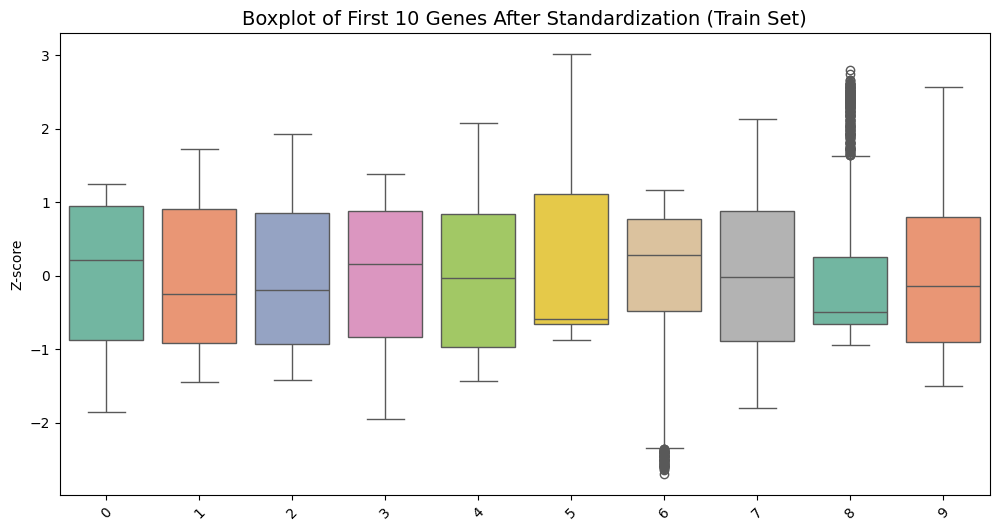

In [145]:

train_df_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Boxplot for first 10 genes
plt.figure(figsize=(12,6))
sns.boxplot(data=train_df_scaled.iloc[:, :10], palette="Set2")
plt.title("Boxplot of First 10 Genes After Standardization (Train Set)", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Z-score")
plt.show()

In [146]:
# 5️⃣ Optional: Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


Class distribution before SMOTE:
Subtype
4    620
3    504
1    213
2    201
6    115
5     53
Name: count, dtype: int64


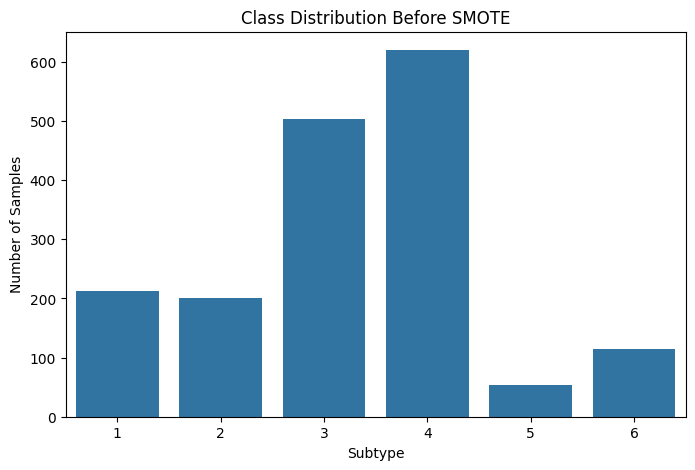

In [147]:
# Counting number of samples in each class
print("Class distribution before SMOTE:")
print(y_train.value_counts())


plt.figure(figsize=(8,5))
sns.countplot(x=y_train)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Subtype")
plt.ylabel("Number of Samples")
plt.show()

In [148]:
from imblearn.over_sampling import SMOTE

# Creating SMOTE object
smote = SMOTE(random_state=42)

# Applying only for training set
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)


print("Class distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

Class distribution after SMOTE:
Subtype
4    620
3    620
2    620
1    620
6    620
5    620
Name: count, dtype: int64


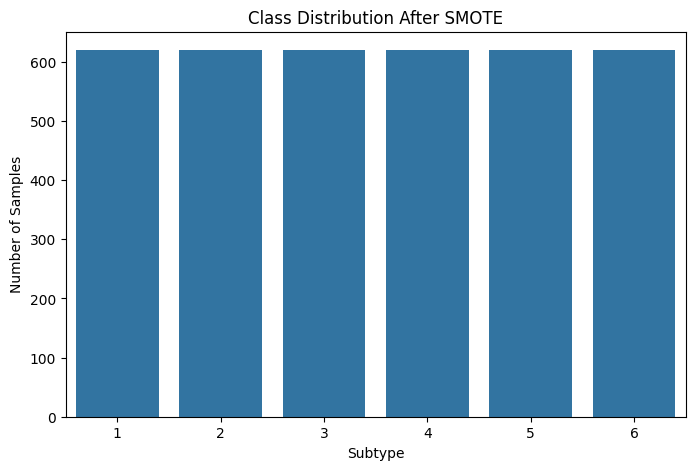

In [149]:
plt.figure(figsize=(8,5))
sns.countplot(x=y_train_res)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Subtype")
plt.ylabel("Number of Samples")
plt.show()


Random Forest Accuracy: 0.9158878504672897

Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.93      0.94        27
           2       0.86      1.00      0.93        25
           3       0.89      0.89      0.89        63
           4       0.94      0.92      0.93        78
           5       0.75      0.50      0.60         6
           6       1.00      1.00      1.00        15

    accuracy                           0.92       214
   macro avg       0.90      0.87      0.88       214
weighted avg       0.92      0.92      0.91       214



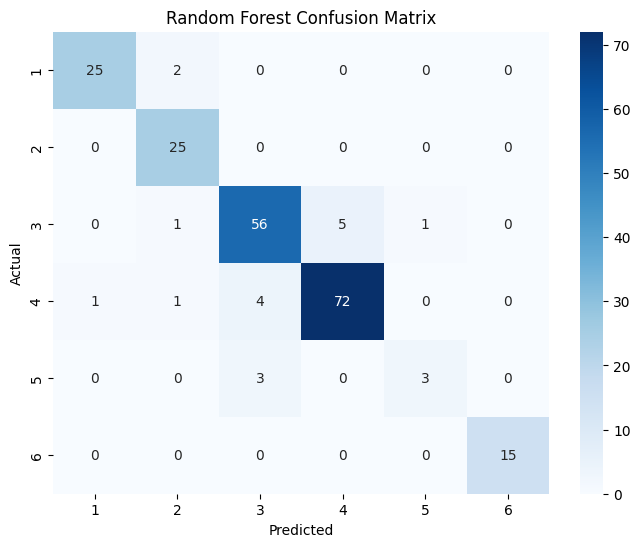

In [150]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

# Train
rf_model.fit(X_train_res, y_train_res)

# Predict
y_pred_rf = rf_model.predict(X_test_scaled)

# Metrics
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[1,2,3,4,5,6],
    yticklabels=[1,2,3,4,5,6]
)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


SVM Accuracy: 0.8878504672897196

Classification Report:
               precision    recall  f1-score   support

           1       0.93      0.93      0.93        27
           2       0.85      0.92      0.88        25
           3       0.91      0.83      0.87        63
           4       0.85      0.91      0.88        78
           5       1.00      0.67      0.80         6
           6       1.00      1.00      1.00        15

    accuracy                           0.89       214
   macro avg       0.92      0.87      0.89       214
weighted avg       0.89      0.89      0.89       214



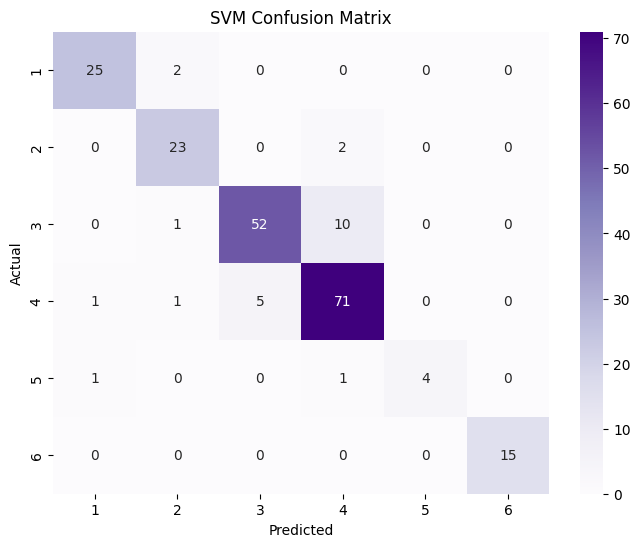

In [151]:
svm_model = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    random_state=42
)

# Train
svm_model.fit(X_train_res, y_train_res)

# Predict
y_pred_svm = svm_model.predict(X_test_scaled)

# Metrics
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=[1,2,3,4,5,6],
    yticklabels=[1,2,3,4,5,6]
)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Train
gb_model.fit(X_train_res, y_train_res)

# Predict
y_pred_gb = gb_model.predict(X_test_scaled)

# Metrics
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))

# Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8,6))
sns.heatmap(
    cm_gb,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=[1,2,3,4,5,6],
    yticklabels=[1,2,3,4,5,6]
)
plt.title("Gradient Boosting Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# Shift labels to start from 0
y_train_res_zero = y_train_res - 1
y_val_zero       = y_val - 1
y_test_zero      = y_test - 1

# Now apply one-hot encoding
from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train_res_zero, num_classes=6)
y_val_ohe   = to_categorical(y_val_zero, num_classes=6)
y_test_ohe  = to_categorical(y_test_zero, num_classes=6)

print("Sample one-hot label:")
print(y_train_ohe[0])


Sample one-hot label:
[0. 0. 0. 1. 0. 0.]


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

input_dim = X_train_res.shape[1]  

# Encoder
inputs = Input(shape=(input_dim,))
encoded = Dense(512, activation='gelu')(inputs)
encoded = Dense(256, activation='gelu')(encoded)
encoded = Dense(128, activation='gelu')(encoded)  # Latent space

# Classifier (Softmax output)
outputs = Dense(6, activation='softmax')(encoded)

# Model
sae_classifier = Model(inputs=inputs, outputs=outputs)

# Compile
sae_classifier.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

sae_classifier.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677,510 (2.58 MB)

 Trainable params: 677,510 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_sae = sae_classifier.fit(
    X_train_res, y_train_ohe,
    validation_data=(X_val, y_val_ohe),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9011 - loss: 0.2783 - val_accuracy: 0.5305 - val_loss: 1.4897
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9702 - loss: 0.0869 - val_accuracy: 0.4038 - val_loss: 1.7054
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9849 - loss: 0.0499 - val_accuracy: 0.5399 - val_loss: 2.0680
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9852 - loss: 0.0457 - val_accuracy: 0.3005 - val_loss: 2.8253
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9960 - loss: 0.0153 - val_accuracy: 0.4648 - val_loss: 2.3026
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9946 - loss: 0.0154 - val_accuracy: 0.5822 - val_loss: 1.9044
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9952 - loss: 0.0192 - val_accuracy: 0.4366 - val_loss: 2.6623
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9739 - loss: 0.1139 - val_accuracy: 0.

In [ ]:
y_pred_probs = sae_classifier.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert y_test_ohe back to integer labels for comparison
y_test_int = np.argmax(y_test_ohe, axis=1)

# Accuracy
accuracy = accuracy_score(y_test_int, y_pred_classes)
print("SAE Test Accuracy:", accuracy)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test_int, y_pred_classes))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
SAE Test Accuracy: 0.9018691588785047

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        27
           1       0.88      0.92      0.90        25
           2       0.91      0.84      0.88        63
           3       0.87      0.92      0.89        78
           4       1.00      0.83      0.91         6
           5       1.00      1.00      1.00        15

    accuracy                           0.90       214
   macro avg       0.93      0.91      0.92       214
weighted avg       0.90      0.90      0.90       214



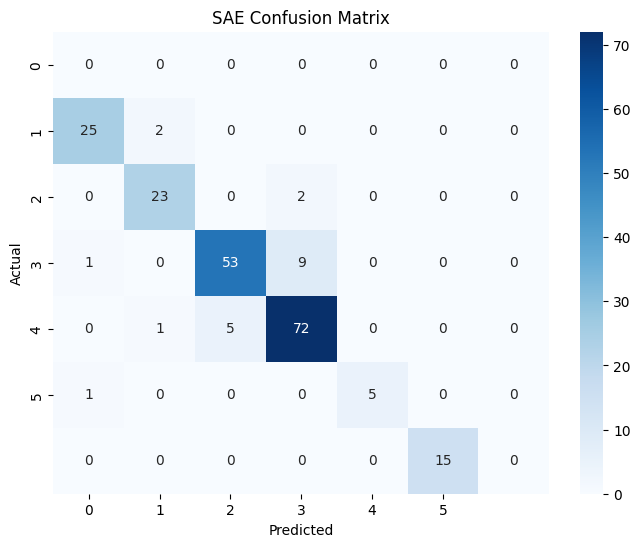

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SAE Confusion Matrix")
plt.show()



### Alternative Architecture Test.

In [ ]:

X_train_cnn = X_train_res.values.reshape(X_train_res.shape[0], X_train_res.shape[1], 1)
X_val_cnn   = X_val_scaled.values.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_cnn  = X_test_scaled.values.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


In [ ]:
print(type(X_train_scaled)) 

<class 'pandas.core.frame.DataFrame'>


In [ ]:
print(X_train_cnn.shape, X_val_cnn.shape, X_test_cnn.shape)

(3720, 1000, 1) (213, 1000, 1) (214, 1000, 1)


In [ ]:
y_train_ohe = to_categorical(y_train_res_zero, num_classes=6)  # после SMOTE
y_val_ohe   = to_categorical(y_val_zero, num_classes=6)        # val
y_test_ohe  = to_categorical(y_test_zero, num_classes=6)       # test


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

cnn_model_strong = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1],1)),
    BatchNormalization(),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv1D(32, kernel_size=3, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(6, activation='softmax')
])

cnn_model_strong.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model_strong.summary()


/Users/saikalulukbekova/Internship/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 998, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 998, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 996, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 996, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 994, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,094 (144.90 KB)

 Trainable params: 36,710 (143.40 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train_res_zero)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_res_zero)
class_weights_dict = dict(zip(classes, class_weights))
print(class_weights_dict)


{np.uint8(0): np.float64(1.0), np.uint8(1): np.float64(1.0), np.uint8(2): np.float64(1.0), np.uint8(3): np.float64(1.0), np.uint8(4): np.float64(1.0), np.uint8(5): np.float64(1.0)}


In [ ]:
history_cnn_strong = cnn_model_strong.fit(
    X_train_cnn, y_train_ohe, 
    epochs=60, 
    batch_size=32, 
    validation_data=(X_val_cnn, y_val_ohe),
    class_weight=class_weights_dict,
    verbose=1
)


Epoch 1/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.3651 - loss: 1.5474 - val_accuracy: 0.1268 - val_loss: 1.6700
Epoch 2/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.4185 - loss: 1.3985 - val_accuracy: 0.1784 - val_loss: 1.5422
Epoch 3/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.4495 - loss: 1.3515 - val_accuracy: 0.3239 - val_loss: 1.4266
Epoch 4/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.4476 - loss: 1.3284 - val_accuracy: 0.4038 - val_loss: 1.2968
Epoch 5/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.4616 - loss: 1.3026 - val_accuracy: 0.4883 - val_loss: 1.2768
Epoch 6/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.4683 - loss: 1.2955 - val_accuracy: 0.3756 - val_loss: 1.4138
Epoch 7/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.4777 - loss: 1.2753 - val_accuracy: 0.3521 - val_loss: 1.3318
Epoch 8/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.4911 - loss: 1.2478 - val_acc

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Enhanced CNN Test Accuracy: 0.45794392523364486

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78        27
           1       0.21      0.68      0.32        25
           2       0.63      0.41      0.50        63
           3       0.50      0.26      0.34        78
           4       0.14      0.33      0.20         6
           5       1.00      0.80      0.89        15

    accuracy                           0.46       214
   macro avg       0.54      0.54      0.50       214
weighted avg       0.57      0.46      0.47       214



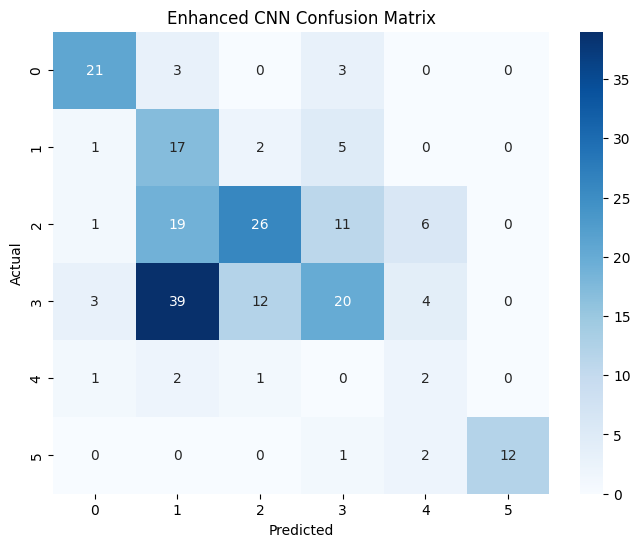

In [ ]:
# Predict probabilities
y_pred_probs = cnn_model_strong.predict(X_test_cnn)

# Convert to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert y_test_ohe back to integer labels
y_test_int = np.argmax(y_test_ohe, axis=1)

# Accuracy
accuracy = accuracy_score(y_test_int, y_pred_classes)
print("Enhanced CNN Test Accuracy:", accuracy)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test_int, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test_int, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4,5], yticklabels=[0,1,2,3,4,5])
plt.title("Enhanced CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
